# ARIMA Model for Time-Series Analysis
## (We are using this model to predict future discounts in our app)

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. 

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.



In [1]:
## DATA CLEANING

from firebase_admin import initialize_app
from firebase_admin import credentials
from firebase_admin import db

# Fetch the service account key JSON file contents
cred = credentials.Certificate('ricehack2018-firebase-adminsdk-ukl68-192239081c.json')
# Initialize the app with a service account, granting admin privileges
initialize_app(cred, {
    'databaseURL': 'https://ricehack2018.firebaseio.com/'
})
ref = db.reference('/offers/users/')
existing_offers = ref.child('729b9a0518abf3f65c9717f2fab9583a').get() or []


import pandas as pd
import numpy as np
import datetime
records_df = pd.DataFrame.from_records(existing_offers)
records_df['offerArrivalDate'] = (pd.to_datetime(records_df['offerArrivalDate'].apply(pd.to_numeric),unit='ms'))
formatted_df = records_df.copy()
formatted_df.set_index('offerArrivalDate', inplace=True)
reformatted_df = formatted_df.copy()[['offerPercentage']]
reformatted_df['offerPercentage'] = (reformatted_df['offerPercentage'].str[:-1].astype(int))
reformatted_df = reformatted_df.resample("M").apply(lambda x: np.average(x.offerPercentage))

In [44]:
formatted_df = formatted_df.drop(['coupon_code'], axis=1)
formatted_df.set_index('offerArrivalDate', inplace=True)

In [124]:
import numpy as np
reformatted_df = formatted_df.copy()[['offerPercentage']]
reformatted_df['offerPercentage'] = (reformatted_df['offerPercentage'].str[:-1].astype(int))
reformatted_df = reformatted_df.resample("M").apply(lambda x: np.average(x.offerPercentage))


In [125]:
# This is the data obtained after cleaning it to suit the input type of the model
reformatted_df

offerArrivalDate
2018-04-30    30.000000
2018-05-31    16.250000
2018-06-30    20.000000
2018-07-31    39.473684
2018-08-31    24.449153
2018-09-30    29.297297
Freq: M, dtype: float64

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                    5
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -17.451
Method:                       css-mle   S.D. of innovations              6.922
Date:                Sun, 16 Sep 2018   AIC                             40.903
Time:                        00:53:11   BIC                             39.731
Sample:                    05-31-2018   HQIC                            37.758
                         - 09-30-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7191      1.860     -0.387      0.725      -4.364       2.926
ar.L1.D2.y    -0.8632      0.158     -5.452      0.012      -1.173      -0.553
                                    Roots           

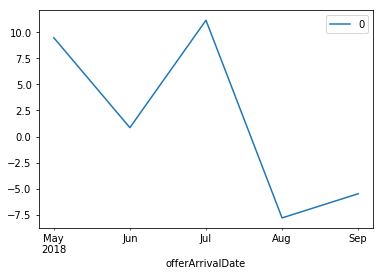

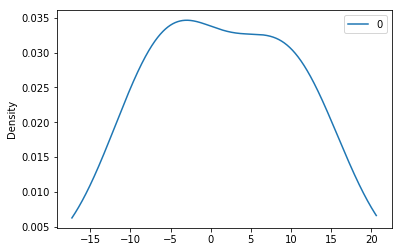

               0
count   5.000000
mean    1.637496
std     8.561154
min    -7.815263
25%    -5.496754
50%     0.852169
75%     9.485360
max    11.161967


In [7]:
# PLOTTING RESIDUAL ERRORS TO GET A FEEL OF HOW GOOD IS THE MODEL TRAINED
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error


# fit model
model = ARIMA(reformatted_df, order=(1,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=21.175752, expected=23.673333
predicted=19.919121, expected=29.660550
Test MSE: 50.567


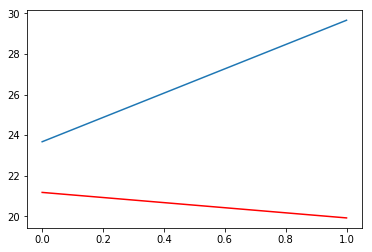

In [30]:
# PREDICTION AND PLOTTING
X = reformatted_df.values
size = int(len(X) * 0.77)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

The mean squared error is huge because of lack of data. This is kind of a POC. Once, we have more data in the database, the predictions will get better. But hence, we can conclude that we can use ARIMA model to somewhat accurately predict the discount timings of a brand spread throughout the year.

# LSTM Model for Time Series Analysis

In [ ]:
# DATA CLEANING USED FOR LSTM POC. THIS IS NOT USED IN OUR APP, BUT WORKS AS EXPECTED

# lst_col = 'brandeClassification'
# formatted_df = pd.DataFrame({
#               col:np.repeat(records_df[col].values, records_df[lst_col].str.len())
#               for col in records_df.columns.difference([lst_col])
#           }).assign(**{lst_col:np.concatenate(records_df[lst_col].values)})[records_df.columns.tolist()]
# category_index = lambda x: 'category_{}'.format(x + 1)
# categories_df = pd.DataFrame(
#                     records_df.classification_category.values.tolist(),
#                     records_df.index, dtype=object
#                 ).rename(columns=category_index)
# formatted_df = pd.concat([records_df.drop('classification_category', axis=1), categories_df], axis=1)
# formatted_df['email_date'] = pd.to_datetime(formatted_df['email_date'], format = '%m/%d/%Y')
# formatted_df = formatted_df.sort_values(by=['email_date'], ascending=True)
# formatted_df['expiry_date'] = pd.to_datetime(df['expiry_date'], format = '%m/%d/%Y')

In [12]:
from sklearn import preprocessing
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

values = formatted_df.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values[:,1] = encoder.fit_transform(values[:,1])
values

array([[0, 2, '30'],
       [0, 4, '30'],
       [0, 1, '30'],
       [2, 2, '20'],
       [2, 4, '20'],
       [2, 3, '20'],
       [1, 2, '40'],
       [1, 0, '40'],
       [0, 2, '30'],
       [0, 4, '30'],
       [0, 1, '30'],
       [2, 2, '20'],
       [2, 4, '20'],
       [2, 3, '20'],
       [1, 2, '40'],
       [1, 0, '40']], dtype=object)

In [30]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	# save model to single file
	model.save('lstm_model.h5')
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features):
	# transform data to be stationary
	raw_values = series.offer.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, features)
	supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	# fit the base model
	lstm_model = fit_lstm(train_scaled, 1, 500, 2)
	# forecast test dataset
	predictions = list()
	for i in range(len(test_scaled)):
		# predict
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]        
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat) 
	print(predictions)    
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('Test RMSE: %.3f' % rmse)
	error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	series = formatted_df.copy()
	series['offer'] = series[['offer']].apply(pd.to_numeric)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	features = 2
	results['results'] = experiment(repeats, series, features)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_features_1.csv', index=False)

 # entry point
run()

[10.25683806836605, 10.06539511680603, 9.922087550163269, 30.36486327648163, 30.36486327648163, 20.31666788458824, 20.202626019716263, 20.167011201381683, 10.208807528018951, 10.183900564908981, 10.15700477361679, 30.36486327648163]
Test RMSE: 14.597
         results
count   1.000000
mean   14.596581
std          NaN
min    14.596581
25%    14.596581
50%    14.596581
75%    14.596581
max    14.596581


Hence, we used ARIMA model and LSTM for Time series Analysis and found ARIMA to be faster and equally good for predicting if the coming months promise a better discount or not. More info can be found on our devpost link.